# Quick Start

One can open this tutorial in Google Colab (is recommended)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/Dev/docs/source/quick_start.ipynb)

In the given short tutorial, we show the basic steps of working with QGOpt. It is known that an arbitrary two qubits unitary gate can be decomposed into a sequence of CNOT gates and one qubit gates as it is shown on the tensor diagram below (if the diagram is not displayed here, please open the notebook in Google Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LuchnikovI/QGOpt/blob/Dev/docs/source/quick_start.ipynb)). ![renorm_layer.png](images/gate_decomposition.png)

Local unitary gates are elements of the complex Stiefel manifold; thus, the decomposition can be found by minimizing Frobenius distance between a given two qubits unitary gate and its decomposition. In the beginning, let us import some libraries.

In [3]:
import tensorflow as tf  # tf 2.x
import matplotlib.pyplot as plt
import math

try:
    import QGOpt as qgo
except ImportError:
    !pip install git+https://github.com/LuchnikovI/QGOpt
    import QGOpt as qgo

# Fix random seed to make results reproducable.
tf.random.set_seed(42)

## Kronecker product function.

Here we define an auxiliary function that returns Kronecker product between two matrices.

In [4]:
def kron(A, B):
    """
    Returns Kronecker product of two square matrices.

    Args:
        A: complex valued tf tensor of shape (dim1, dim1)
        B: complex valued tf tensor of shape (dim2, dim2)

    Returns:
        complex valued tf tensor of shape (dim1 * dim2, dim1 * dim2),
        kronecker product of two matrices
    """
    
    dim1 = A.shape[-1]
    dim2 = B.shape[-1]
    AB = tf.transpose(tf.tensordot(A, B, axes=0), (0, 2, 1, 3))
    return tf.reshape(AB, (dim1 * dim2, dim1 * dim2))

## A random two qubit gate and parameters of its decomposition.

Here we define a random two qubit gate to decompose and initialize building blocks of its decomposition (CNOT gate and local unitary gates).

In [5]:
#=======================================================================#
circuit_length = 4  # circuit length (number of layers with local gates)
#=======================================================================#

# cnot gate
cnot = tf.constant([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0]], dtype=tf.complex128)

# complex Stiefel manifold
m = qgo.manifolds.StiefelManifold()
# random two qubit gate to decompose
target_U = m.random((4, 4), dtype=tf.complex128)

# initial local unitary gates (will be optimized)
u_1 = [m.random((2, 2), dtype=tf.complex128) for _ in range(circuit_length)]
u_2 = [m.random((2, 2), dtype=tf.complex128) for _ in range(circuit_length)]

# real representation of local unitary gates
u_1 = list(map(qgo.manifolds.complex_to_real, u_1))
u_2 = list(map(qgo.manifolds.complex_to_real, u_2))

## Optimization loop.

Here we minimize the Frobenius distance between the target two qubit gate and its decomposition.

In [6]:
#=================================#
iters = 500 # number of iterations
lr = 0.2 # learning rate
#=================================#


# complex Stiefel manifold
m = qgo.manifolds.StiefelManifold()
# Riemannian Adam optimizer
opt = qgo.optimizers.RAdam(m, lr, ams=True)

# transforming initial local unitary gates to tf.Variables
varu_1 = list(map(tf.Variable, u_1))
varu_2 = list(map(tf.Variable, u_2))

errs = [] # will be filled by err vs iteration number

for _ in range(iters):
    with tf.GradientTape() as tape:
        # transforming real variables to complex representation
        varu_1c = list(map(qgo.manifolds.real_to_complex, varu_1))
        varu_2c = list(map(qgo.manifolds.real_to_complex, varu_2))

        # gate decomposition
        gate = kron(varu_1c[0], varu_2c[0])
        for i in range(1, len(varu_1c)):
            gate = cnot @ gate
            gate = kron(varu_1c[i], varu_2c[i]) @ gate

        # square of Frobenius distance between the target gate and its 
        # decomposition
        d = gate - target_U
        loss = tf.linalg.norm(d) ** 2
        
    errs.append(tf.math.sqrt(loss))
    
    grad = tape.gradient(loss, varu_1 + varu_2)  # gradient
    opt.apply_gradients(zip(grad, varu_1 + varu_2))  # optimization step

## Plotting of the Frobenius distance between the target gate and its decomposition

[0, 0] element of trained gate (-0.5406855415008305+0.14969542158487123j)
[0, 0] element of target gate (-0.5406855414988629+0.14969542158363175j)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'err')

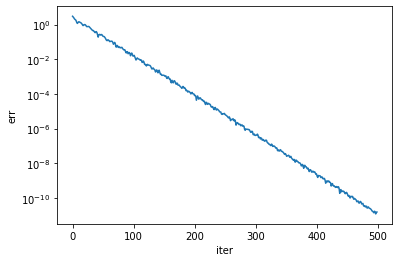

In [8]:
print('[0, 0] element of trained gate', gate[0, 0].numpy())
print('[0, 0] element of target gate', target_U[0, 0].numpy())
plt.plot(errs)
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')